# Course4
## Time Series and Prediction
## Week3

# RNN

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

### Callback

Here's the code for training the RNN with two layers each with 40 cells.

To tune the learning rate, we'll set up **a callback,** which you can see here. Every epoch this just changes the learning rate a little so that it steps all the way from 1 * 10 to the - 8 to 1 * 10 to the -6. You can see that setup here while training.

### Huber

I've also introduced **a new loss function** to use called **Huber** which you can see here. The Huber function is **a loss function that's less sensitive to outliers** and as this data can get a little bit noisy, it's worth giving it a shot.

If I run this for 100 epochs and measure the loss at each epoch, I will see that my optimum learning rate for stochastic gradient descent is between about 10 to the -5 and 10 to the -6. So I'm going to set it’s 5 times 10 to the minus 5.

More info on Huber loss : https://en.wikipedia.org/wiki/Huber_loss

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 194.7820 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 193.5109 - mae: 194.0109 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 185.3786 - mae: 185.8786 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 182.5483 - mae: 183.0483 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 179.3126 - mae: 179.8126

8/8 [==============================] - 0s 7ms/step - loss: 8.9662 - mae: 9.4572 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 5ms/step - loss: 9.9614 - mae: 10.4540 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 6ms/step - loss: 10.2042 - mae: 10.6953 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 5ms/step - loss: 8.7450 - mae: 9.2364 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 8.0933 - mae: 8.5806 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 6ms/step - loss: 12.0837 - mae: 12.5733 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 5ms/step - loss: 21.2995 - mae: 21.7951 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 8ms/step - loss: 15.5183 - mae: 16.0124 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 7ms/step - loss: 17.7744 - mae: 18.2671 - lr: 1.1220e-04
Epoch 83/100

[1e-08, 0.0001, 0, 30]

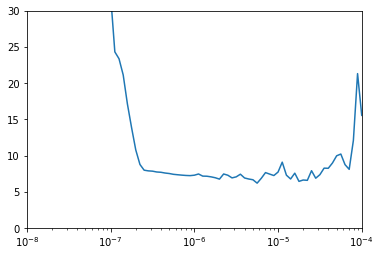

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Adjusting the learning rate dynamically

After training for 500 epochs, an MAE on the validation set of about 6.35. It's not bad, but I wonder if we can do better. So here's the loss and the MAE during training with the chart on the right is zoomed into the last few epochs. As you can see, the trend was genuinely downward until a little after 400 epochs, when it started getting unstable. Given this, it's probably worth only training for about 400 epochs.

When I do that, I get these results. That’s pretty much the same with the MAE only a tiny little bit higher, but we've saved 100 epochs worth of training to get it. So it's worth it!

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 8ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 6ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 7ms/step - loss: 15.9199 - mae: 16.4142
Epoch 4/400
8/8 [==============================] - 0s 7ms/step - loss: 12.2877 - mae: 12.7812
Epoch 5/400
8/8 [==============================] - 0s 7ms/step - loss: 10.1472 - mae: 10.6373
Epoch 6/400
8/8 [==============================] - 0s 6ms/step - loss: 16.6924 - mae: 17.1866
Epoch 7/400
8/8 [==============================] - 0s 7ms/step - loss: 13.1498 - mae: 13.6422
Epoch 8/400
8/8 [==============================] - 0s 6ms/step - loss: 10.2348 - mae: 10.7232
Epoch 9/400
8/8 [==============================] - 0s 7ms/step - loss: 11.1116 - mae: 11.6020
Epoch 10/400
8/8 [==============================] - 0s 7ms/step - loss: 14.1436 - mae: 14.6385
Epoch 11/400
8/8 [==============================] - 0s 6ms/

8/8 [==============================] - 0s 5ms/step - loss: 5.0334 - mae: 5.5168
Epoch 89/400
8/8 [==============================] - 0s 6ms/step - loss: 5.9630 - mae: 6.4488
Epoch 90/400
8/8 [==============================] - 0s 7ms/step - loss: 6.3576 - mae: 6.8407
Epoch 91/400
8/8 [==============================] - 0s 10ms/step - loss: 5.0321 - mae: 5.5107
Epoch 92/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8178 - mae: 5.2972
Epoch 93/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5613 - mae: 5.0355
Epoch 94/400
8/8 [==============================] - 0s 5ms/step - loss: 5.2251 - mae: 5.7064
Epoch 95/400
8/8 [==============================] - 0s 5ms/step - loss: 4.9745 - mae: 5.4584
Epoch 96/400
8/8 [==============================] - 0s 5ms/step - loss: 5.2277 - mae: 5.7073
Epoch 97/400
8/8 [==============================] - 0s 6ms/step - loss: 5.9105 - mae: 6.3939
Epoch 98/400
8/8 [==============================] - 0s 6ms/step - loss: 5.9303 - m

8/8 [==============================] - 0s 6ms/step - loss: 6.4605 - mae: 6.9455
Epoch 176/400
8/8 [==============================] - 0s 5ms/step - loss: 4.9604 - mae: 5.4387
Epoch 177/400
8/8 [==============================] - 0s 7ms/step - loss: 4.7413 - mae: 5.2190
Epoch 178/400
8/8 [==============================] - 0s 6ms/step - loss: 5.6941 - mae: 6.1777
Epoch 179/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6720 - mae: 5.1545
Epoch 180/400
8/8 [==============================] - 0s 5ms/step - loss: 4.2514 - mae: 4.7259
Epoch 181/400
8/8 [==============================] - 0s 8ms/step - loss: 4.9201 - mae: 5.3984
Epoch 182/400
8/8 [==============================] - 0s 7ms/step - loss: 4.4062 - mae: 4.8859
Epoch 183/400
8/8 [==============================] - 0s 7ms/step - loss: 4.5804 - mae: 5.0555A: 0s - loss: 4.5804 - mae: 5.055
Epoch 184/400
8/8 [==============================] - 0s 7ms/step - loss: 4.8531 - mae: 5.3306
Epoch 185/400
8/8 [======================

Epoch 262/400
8/8 [==============================] - 0s 7ms/step - loss: 5.1192 - mae: 5.5995
Epoch 263/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9342 - mae: 5.4103
Epoch 264/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5354 - mae: 5.0109
Epoch 265/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9795 - mae: 5.4595
Epoch 266/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3873 - mae: 4.8602
Epoch 267/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3816 - mae: 4.8618
Epoch 268/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4946 - mae: 4.9697
Epoch 269/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3523 - mae: 4.8249
Epoch 270/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4223 - mae: 4.8998
Epoch 271/400
8/8 [==============================] - 0s 6ms/step - loss: 5.1316 - mae: 5.6114
Epoch 272/400
8/8 [==============================] - 0s 5ms/

8/8 [==============================] - 0s 6ms/step - loss: 5.1935 - mae: 5.6762
Epoch 350/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7071 - mae: 5.1882
Epoch 351/400
8/8 [==============================] - 0s 5ms/step - loss: 6.0705 - mae: 6.5516
Epoch 352/400
8/8 [==============================] - 0s 8ms/step - loss: 6.2047 - mae: 6.6886
Epoch 353/400
8/8 [==============================] - 0s 6ms/step - loss: 6.7252 - mae: 7.2139
Epoch 354/400
8/8 [==============================] - 0s 7ms/step - loss: 4.5498 - mae: 5.0263
Epoch 355/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6589 - mae: 5.1389
Epoch 356/400
8/8 [==============================] - 0s 5ms/step - loss: 4.5406 - mae: 5.0178
Epoch 357/400
8/8 [==============================] - 0s 7ms/step - loss: 4.7654 - mae: 5.2407
Epoch 358/400
8/8 [==============================] - 0s 7ms/step - loss: 6.4241 - mae: 6.9106
Epoch 359/400
8/8 [==============================] - 0s 6ms/step - loss: 4

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.814622

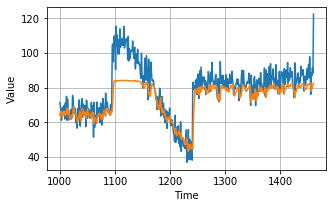

In [15]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(5, 3))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.959649

<Figure size 432x288 with 0 Axes>

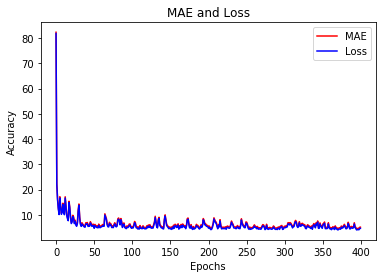

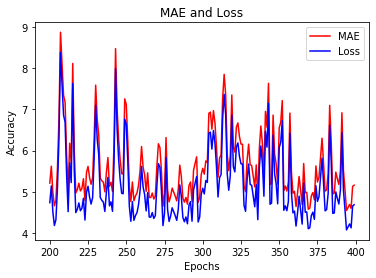

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# LSTM

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

- First of all is the **tf.keras.backend.clear_session,** and this **clears any internal variables.** That makes it easy for us to experiment without models impacting later versions of themselves.
- After the **Lambda** layer that **expands the dimensions for us** I've **added a single LSTM layer** with 32 cells. I've also made a bidirectional to see the impact of that on a prediction.
- **Let's add another LSTM** to see the impact. Now you can see the second layer and **note that we had to set return sequences equal to true on the first one** in order for this to work.
- The output neuron will give us our prediction value.
- I'm also using a **learning rate** of one times 10 times minus eight and that might be worth experimenting with too.

When you add the second LSTM, it's tracking much better and closer to the original data. Maybe not keeping up with the sharp increase but at least it's tracking close. It also gives us a mean average error that's a lot better and it's showing that we're heading in the right direction.

If we **add a third LSTM** layer like this, and have **the second layer return sequences is true**, there's really not that much of a difference and are MAE has actually gone down.

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08616 - mae: 19
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 1

31/31 [==============================] - 0s 12ms/step - loss: 5.2213 - mae: 5.6963 - lr: 3.5481e-05
Epoch 73/100
31/31 [==============================] - 0s 12ms/step - loss: 5.9186 - mae: 6.4005 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 12ms/step - loss: 6.1640 - mae: 6.6490 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 12ms/step - loss: 6.7896 - mae: 7.2732 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 12ms/step - loss: 5.2215 - mae: 5.7012 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 13ms/step - loss: 5.5952 - mae: 6.0767 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 14ms/step - loss: 5.3833 - mae: 5.8619 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3766 - mae: 5.8558 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 13ms/step - loss: 5.1743 - mae: 5.6515 - lr: 8.9125e

So here's the results of running this LSTM on the synthetic data that we've been using throughout the course. The plateau under the big spike is still there and MAE is in the low sixes. It's not bad, it's not great, but it's not bad. The predictions look like there might be a little bit on the low side too.

[1e-08, 0.0001, 0, 30]

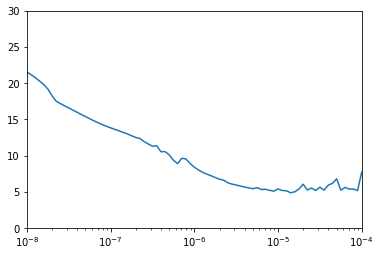

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

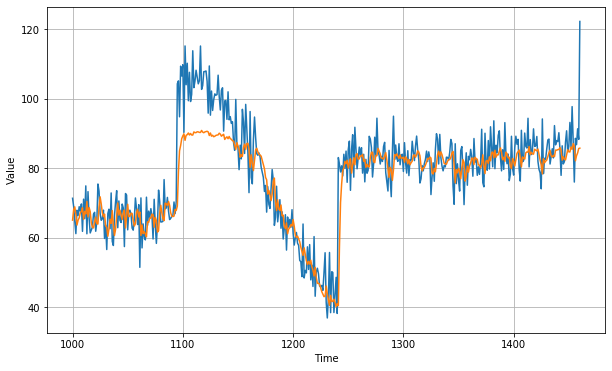

In [20]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6518984

<Figure size 432x288 with 0 Axes>

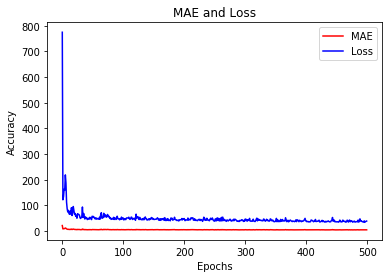

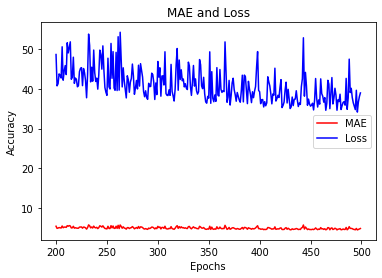

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [23]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [24]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 755.7013
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 152.7785
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 97.9761
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 83.2915
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 78.2600
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 73.4347
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 67.8632
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 74.5354
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 73.1458
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 63.4809
Epoch 11/100
31/31 [==============================] - 1s 19ms/step - loss: 60.9757
Epoch 12/100
31/31 [==============================] - 1s 17ms/step - loss: 57.7044
Epoch 13/10

31/31 [==============================] - 1s 17ms/step - loss: 45.3499
Epoch 100/100
31/31 [==============================] - 1s 17ms/step - loss: 46.9555
